# Assignment 3



In [1]:
import pandas as pd
from collections import Counter as ctr
from operator import itemgetter
import numpy as np
from sklearn.metrics import accuracy_score
import seaborn as sn
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

### Training dataset

In [2]:
train = pd.read_csv('train.txt', delimiter=' ', names=['word', 'pos', 'other'])
train['word'] = train.word.str.lower()
train.head()

,word,pos,other
0,confidence,NN,B-NP
1,in,IN,B-PP
2,the,DT,B-NP
3,pound,NN,I-NP
4,is,VBZ,B-VP


### Generating ppos column

In [3]:
train['ppos'] = train.pos.shift(1)
train['ppos'] = train.ppos.fillna('O')
train.head()

,word,pos,other,ppos
0,confidence,NN,B-NP,O
1,in,IN,B-PP,NN
2,the,DT,B-NP,IN
3,pound,NN,I-NP,DT
4,is,VBZ,B-VP,NN


In [4]:
pos = list(set(train.pos))
smooth = 0.00001

print(pos)

[',', 'EX', 'CD', 'JJ', 'DT', 'WRB', 'NN', '(', 'RBR', 'RBS', 'SYM', 'RB', 'PRP', 'WP$', '``', 'NNPS', 'CC', 'NNP', 'PRP$', 'VBN', '.', 'VBZ', 'RP', 'VBD', '$', 'PDT', 'JJR', ')', 'TO', 'VBG', 'VBP', 'VB', 'IN', '#', "''", ':', 'MD', 'UH', 'WP', 'JJS', 'FW', 'NNS', 'POS', 'WDT']


### Functions to calculate emission and transition probablity

In [5]:
pos_ppos = {}
pos_ppos_denom = {}

for col_name in set(train.ppos):
    sub_frame = train[train.ppos == col_name]
    counted = ctr(sub_frame.pos)
    pos_ppos[col_name] = counted
    pos_ppos_denom[col_name] = len(sub_frame)
    
# conditional 
def Ptt(Ti,Tprev):
    if Ti not in pos_ppos[Tprev]: return smooth
    return pos_ppos[Tprev][Ti] / pos_ppos_denom[Tprev]

word_pos = {}
word_pos_denom = {}
for col_name in set(train.pos):
    sub_frame = train[train.pos == col_name]
    counted = ctr(sub_frame.word)
    word_pos[col_name] = counted
    word_pos_denom[col_name] = len(sub_frame)
    
# conditional 
def Pwt(W, T):
    if W not in word_pos[T]: return smooth
    return word_pos[T][W] / word_pos_denom[T]

In [6]:
Pwt('the','DT')

0.583419689119171

### Function for probablity matrix

In [7]:
def build_matrix(sequence):
    emissions = []
    transitions = []
    
    for word in sequence:
        emission = [(t,Pwt(word, t)) for t in pos]
        for ti in pos:
            transition = []
            for tprev,prob in emission:
                transition.append((tprev,Ptt(ti,tprev)))
            transitions.append(transition)
        emissions.append(emission)
        
    emission_df = pd.DataFrame(emissions)
    emission_df.index = sequence
    emission_df.columns = pos
    
    transition_df = pd.DataFrame(transitions)
    transition_df = transition_df.iloc[0:len(pos), :]
    transition_df.index = pos
    transition_df.columns = pos
        
    return emission_df.T, transition_df.T

### Viterbi algorithm

In [8]:
def viterbi(obs, states, start_p, trans_p, emit_p):
    V = [{}]
    for st in states:
        V[0][st] = {"prob": emit_p[st][obs[0]], "prev": None}
    # Run Viterbi when t > 0
    for t in range(1, len(obs)):
        V.append({})
        for st in states:
            max_tr_prob = V[t-1][states[0]]["prob"]*trans_p[states[0]][st]
            prev_st_selected = states[0]
            for prev_st in states[1:]:
                tr_prob = V[t-1][prev_st]["prob"]*trans_p[prev_st][st]
                if tr_prob > max_tr_prob:
                    max_tr_prob = tr_prob
                    prev_st_selected = prev_st
                    
            max_prob = max_tr_prob * emit_p[st][obs[t]]
            V[t][st] = {"prob": max_prob, "prev": prev_st_selected}
                    
    opt = []
    # The highest probability
    max_prob = max(value["prob"] for value in V[-1].values())
    previous = None
    # Get most probable state and its backtrack
    for st, data in V[-1].items():
        if data["prob"] == max_prob:
            opt.append(st)
            previous = st
            break
    # Follow the backtrack till the first observation
    for t in range(len(V) - 2, -1, -1):
        opt.insert(0, V[t + 1][previous]["prev"])
        previous = V[t + 1][previous]["prev"]

    return opt

The above function has the following paramters i.e. obs - observations, states - hidden states, start_p - start probability of the trellis, trans_p - transition probability matrix, emit_p - emission probability. 

### Evaluation

#### Test dataset

In [9]:
test = pd.read_csv('test.txt', delimiter=' ', names=['word', 'pos', 'other'])
test['word'] = test.word.str.lower()
test.head()

,word,pos,other
0,rockwell,NNP,B-NP
1,international,NNP,I-NP
2,corp.,NNP,I-NP
3,'s,POS,B-NP
4,tulsa,NNP,I-NP


#### Sentence from test dataset

In [10]:
sentences = []

sentence = []
for word in test['word']:
    if word != '.':
        sentence.append(word)
    else:
        sentence.append(word)
        sentences.append(sentence)
        sentence = []

### Generation of sentence wise hypothesis in a list

In [11]:
my_hyp = []

for sentence in sentences:
    obs = sentence
    
    e_df, t_df = build_matrix(obs)
    states = pos

    trans_p = {}
    for i in range(0, len(t_df)):
      trans_p[t_df.index[i]] = {}
      for ind, value in enumerate(list(t_df.iloc[i])):
        trans_p[t_df.index[i]].update({t_df.columns[ind] : value[1]}) 

    emit_p = {}
    for i in range(0, len(e_df)):
      emit_p[e_df.index[i]] = {}
      for ind, value in enumerate(list(e_df.iloc[i])):
        emit_p[e_df.index[i]].update({e_df.columns[ind] : value[1]})      

    start_p = dict(t_df.WDT.apply(lambda x: x[1])) 
    
    my_hyp += viterbi(obs, states, start_p, trans_p, emit_p)

### Emission probability

In [12]:
e_df

,in,los,angeles,",",for,example,",",central,has,had,...,has,been,less,prominent,",",according,to,mr.,harlow,.
",","(,, 1e-05)","(,, 1e-05)","(,, 1e-05)","(,, 1.0)","(,, 1e-05)","(,, 1e-05)","(,, 1.0)","(,, 1e-05)","(,, 1e-05)","(,, 1e-05)",...,"(,, 1e-05)","(,, 1e-05)","(,, 1e-05)","(,, 1e-05)","(,, 1.0)","(,, 1e-05)","(,, 1e-05)","(,, 1e-05)","(,, 1e-05)","(,, 1e-05)"
EX,"(EX, 1e-05)","(EX, 1e-05)","(EX, 1e-05)","(EX, 1e-05)","(EX, 1e-05)","(EX, 1e-05)","(EX, 1e-05)","(EX, 1e-05)","(EX, 1e-05)","(EX, 1e-05)",...,"(EX, 1e-05)","(EX, 1e-05)","(EX, 1e-05)","(EX, 1e-05)","(EX, 1e-05)","(EX, 1e-05)","(EX, 1e-05)","(EX, 1e-05)","(EX, 1e-05)","(EX, 1e-05)"
CD,"(CD, 1e-05)","(CD, 1e-05)","(CD, 1e-05)","(CD, 1e-05)","(CD, 1e-05)","(CD, 1e-05)","(CD, 1e-05)","(CD, 1e-05)","(CD, 1e-05)","(CD, 1e-05)",...,"(CD, 1e-05)","(CD, 1e-05)","(CD, 1e-05)","(CD, 1e-05)","(CD, 1e-05)","(CD, 1e-05)","(CD, 1e-05)","(CD, 1e-05)","(CD, 1e-05)","(CD, 1e-05)"
JJ,"(JJ, 1e-05)","(JJ, 1e-05)","(JJ, 1e-05)","(JJ, 1e-05)","(JJ, 7.642338555598012e-05)","(JJ, 1e-05)","(JJ, 1e-05)","(JJ, 0.0009935040122277417)","(JJ, 1e-05)","(JJ, 1e-05)",...,"(JJ, 1e-05)","(JJ, 1e-05)","(JJ, 1e-05)","(JJ, 1e-05)","(JJ, 1e-05)","(JJ, 1e-05)","(JJ, 1e-05)","(JJ, 1e-05)","(JJ, 1e-05)","(JJ, 1e-05)"
DT,"(DT, 1e-05)","(DT, 1e-05)","(DT, 1e-05)","(DT, 1e-05)","(DT, 1e-05)","(DT, 1e-05)","(DT, 1e-05)","(DT, 1e-05)","(DT, 1e-05)","(DT, 1e-05)",...,"(DT, 1e-05)","(DT, 1e-05)","(DT, 1e-05)","(DT, 1e-05)","(DT, 1e-05)","(DT, 1e-05)","(DT, 1e-05)","(DT, 1e-05)","(DT, 1e-05)","(DT, 1e-05)"
WRB,"(WRB, 1e-05)","(WRB, 1e-05)","(WRB, 1e-05)","(WRB, 1e-05)","(WRB, 1e-05)","(WRB, 1e-05)","(WRB, 1e-05)","(WRB, 1e-05)","(WRB, 1e-05)","(WRB, 1e-05)",...,"(WRB, 1e-05)","(WRB, 1e-05)","(WRB, 1e-05)","(WRB, 1e-05)","(WRB, 1e-05)","(WRB, 1e-05)","(WRB, 1e-05)","(WRB, 1e-05)","(WRB, 1e-05)","(WRB, 1e-05)"
NN,"(NN, 0.0004975619464623346)","(NN, 1e-05)","(NN, 1e-05)","(NN, 1e-05)","(NN, 1e-05)","(NN, 0.0017580522108335821)","(NN, 1e-05)","(NN, 1e-05)","(NN, 1e-05)","(NN, 1e-05)",...,"(NN, 1e-05)","(NN, 1e-05)","(NN, 1e-05)","(NN, 1e-05)","(NN, 1e-05)","(NN, 1e-05)","(NN, 1e-05)","(NN, 1e-05)","(NN, 1e-05)","(NN, 1e-05)"
(,"((, 1e-05)","((, 1e-05)","((, 1e-05)","((, 1e-05)","((, 1e-05)","((, 1e-05)","((, 1e-05)","((, 1e-05)","((, 1e-05)","((, 1e-05)",...,"((, 1e-05)","((, 1e-05)","((, 1e-05)","((, 1e-05)","((, 1e-05)","((, 1e-05)","((, 1e-05)","((, 1e-05)","((, 1e-05)","((, 1e-05)"
RBR,"(RBR, 1e-05)","(RBR, 1e-05)","(RBR, 1e-05)","(RBR, 1e-05)","(RBR, 1e-05)","(RBR, 1e-05)","(RBR, 1e-05)","(RBR, 1e-05)","(RBR, 1e-05)","(RBR, 1e-05)",...,"(RBR, 1e-05)","(RBR, 1e-05)","(RBR, 0.07165109034267912)","(RBR, 1e-05)","(RBR, 1e-05)","(RBR, 1e-05)","(RBR, 1e-05)","(RBR, 1e-05)","(RBR, 1e-05)","(RBR, 1e-05)"
RBS,"(RBS, 1e-05)","(RBS, 1e-05)","(RBS, 1e-05)","(RBS, 1e-05)","(RBS, 1e-05)","(RBS, 1e-05)","(RBS, 1e-05)","(RBS, 1e-05)","(RBS, 1e-05)","(RBS, 1e-05)",...,"(RBS, 1e-05)","(RBS, 1e-05)","(RBS, 1e-05)","(RBS, 1e-05)","(RBS, 1e-05)","(RBS, 1e-05)","(RBS, 1e-05)","(RBS, 1e-05)","(RBS, 1e-05)","(RBS, 1e-05)"


### Transition probability

In [13]:
t_df

,",",EX,CD,JJ,DT,WRB,NN,(,RBR,RBS,...,'',:,MD,UH,WP,JJS,FW,NNS,POS,WDT
",","(,, 1e-05)","(,, 0.002785515320334262)","(,, 0.019220055710306407)","(,, 0.03899721448467967)","(,, 0.1338904363974002)","(,, 0.006128133704735376)","(,, 0.051624883936861654)","(,, 9.285051067780872e-05)","(,, 0.0005571030640668524)","(,, 0.001392757660167131)",...,"(,, 0.05738161559888579)","(,, 9.285051067780872e-05)","(,, 0.00872794800371402)","(,, 9.285051067780872e-05)","(,, 0.010492107706592386)","(,, 1e-05)","(,, 9.285051067780872e-05)","(,, 0.028783658310120707)","(,, 0.00018570102135561745)","(,, 0.03351903435468895)"
EX,"(EX, 0.03398058252427184)","(EX, 1e-05)","(EX, 1e-05)","(EX, 1e-05)","(EX, 0.009708737864077669)","(EX, 1e-05)","(EX, 1e-05)","(EX, 1e-05)","(EX, 1e-05)","(EX, 1e-05)",...,"(EX, 1e-05)","(EX, 0.0048543689320388345)","(EX, 0.11165048543689321)","(EX, 1e-05)","(EX, 1e-05)","(EX, 1e-05)","(EX, 1e-05)","(EX, 1e-05)","(EX, 1e-05)","(EX, 1e-05)"
CD,"(CD, 0.10378833433553819)","(CD, 1e-05)","(CD, 0.19819603126879135)","(CD, 0.037161755862898375)","(CD, 0.031629585087191825)","(CD, 0.0007215874924834636)","(CD, 0.20384846662657846)","(CD, 0.0016837041491280817)","(CD, 0.00012026458208057727)","(CD, 0.00012026458208057727)",...,"(CD, 0.0003607937462417318)","(CD, 0.00613349368610944)","(CD, 0.0020444978953698136)","(CD, 1e-05)","(CD, 0.0006013229104028864)","(CD, 0.0008418520745640408)","(CD, 1e-05)","(CD, 0.14419723391461214)","(CD, 0.0009621166566446182)","(CD, 0.0010823812387251955)"
JJ,"(JJ, 0.028200229270156668)","(JJ, 1e-05)","(JJ, 0.015437523882307987)","(JJ, 0.07329002674818494)","(JJ, 0.00588460068781047)","(JJ, 0.0006878104700038212)","(JJ, 0.4580053496369889)","(JJ, 0.000611387084447841)","(JJ, 7.642338555598012e-05)","(JJ, 0.00015284677111196025)",...,"(JJ, 0.004508979747802827)","(JJ, 0.002751241880015285)","(JJ, 0.000611387084447841)","(JJ, 1e-05)","(JJ, 0.0005349636988918609)","(JJ, 0.0003056935422239205)","(JJ, 7.642338555598012e-05)","(JJ, 0.22506687046236148)","(JJ, 1e-05)","(JJ, 0.0005349636988918609)"
DT,"(DT, 0.0023452413416962096)","(DT, 1e-05)","(DT, 0.025743114262339786)","(DT, 0.19890919007362967)","(DT, 0.001308971911644396)","(DT, 1e-05)","(DT, 0.48453776929370057)","(DT, 0.000436323970548132)","(DT, 0.0013635124079629125)","(DT, 0.003054267793836924)",...,"(DT, 1e-05)","(DT, 0.0004908644668666485)","(DT, 0.001745295882192528)","(DT, 0.000218161985274066)","(DT, 0.000654485955822198)","(DT, 0.00932642487046632)","(DT, 0.0001636214889555495)","(DT, 0.07324788655576765)","(DT, 1e-05)","(DT, 0.000218161985274066)"
WRB,"(WRB, 0.0041841004184100415)","(WRB, 0.008368200836820083)","(WRB, 0.008368200836820083)","(WRB, 0.08158995815899582)","(WRB, 0.26359832635983266)","(WRB, 1e-05)","(WRB, 0.07322175732217573)","(WRB, 1e-05)","(WRB, 1e-05)","(WRB, 1e-05)",...,"(WRB, 1e-05)","(WRB, 1e-05)","(WRB, 0.010460251046025104)","(WRB, 1e-05)","(WRB, 1e-05)","(WRB, 1e-05)","(WRB, 1e-05)","(WRB, 0.07531380753138076)","(WRB, 1e-05)","(WRB, 0.0020920502092050207)"
NN,"(NN, 0.11248217069691843)","(NN, 0.00033170796430822305)","(NN, 0.0054068398182240355)","(NN, 0.010017580522108336)","(NN, 0.007761966364812419)","(NN, 0.0019902477858493384)","(NN, 0.11772315653298836)","(NN, 0.0017912230072644043)","(NN, 0.0038478123859753874)","(NN, 0.0001990247785849338)",...,"(NN, 0.005207815039639102)","(NN, 0.011477095565064517)","(NN, 0.018177596444090623)","(NN, 1e-05)","(NN, 0.0024546389358808506)","(NN, 1e-05)","(NN, 0.00016585398215411152)","(NN, 0.08495040965933592)","(NN, 0.02202540883006601)","(NN, 0.007861478754104886)"
(,"((, 1e-05)","((, 0.0036496350364963502)","((, 0.058394160583941604)","((, 0.051094890510948905)","((, 0.09854014598540146)","((, 0.0036496350364963502)","((, 0.0364963503649635)","((, 1e-05)","((, 1e-05)","((, 1e-05)",...,"((, 1e-05)","((, 1e-05)","((, 1e-05)","((, 1e-05)","((, 0.0072992700729927005)","((, 1e-05)","((, 1e-05)","((, 0.021897810218978103)","((, 1e-05)","((, 0.0072992700729927005)"
RBR,"(RBR, 0.0654

### Evaluation

In [14]:
test['hyp'] = my_hyp
test.head()

,word,pos,other,hyp
0,rockwell,NNP,B-NP,FW
1,international,NNP,I-NP,NNP
2,corp.,NNP,I-NP,NNP
3,'s,POS,B-NP,POS
4,tulsa,NNP,I-NP,JJ


In [15]:
accuracy_score(test.pos, test.hyp)  # accuracy score

0.9215442092154421

In [16]:
conf_matrix = confusion_matrix(test.pos, test.hyp)
df_cm = pd.DataFrame(conf_matrix, index = [i for i in pos], columns = [i for i in pos])

In [17]:
pos

[',',
 'EX',
 'CD',
 'JJ',
 'DT',
 'WRB',
 'NN',
 '(',
 'RBR',
 'RBS',
 'SYM',
 'RB',
 'PRP',
 'WP$',
 '``',
 'NNPS',
 'CC',
 'NNP',
 'PRP$',
 'VBN',
 '.',
 'VBZ',
 'RP',
 'VBD',
 '$',
 'PDT',
 'JJR',
 ')',
 'TO',
 'VBG',
 'VBP',
 'VB',
 'IN',
 '#',
 "''",
 ':',
 'MD',
 'UH',
 'WP',
 'JJS',
 'FW',
 'NNS',
 'POS',
 'WDT']

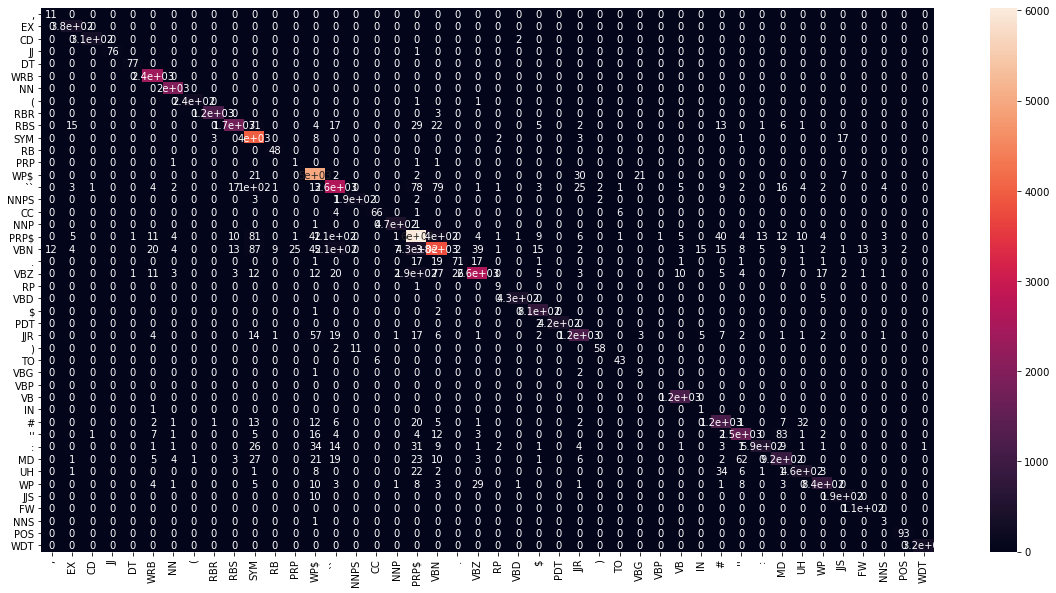

In [18]:
plt.figure(figsize = (20,10))
sn.heatmap(df_cm, annot=True)

In the above generated confusion matrix, the diagonal represents the gold POS tags matching with the predicted POS tags. The other ones is in generally the wrong ones while comparing the predictions. For example VBZ is woringly predicted as WDT, WRB etc. 

In [19]:
# from client.api.notebook import Notebook
# ok = Notebook('a3.ok')
# ok.auth(inline=True, force=True)

In [20]:
# ok.submit()